In [252]:
import sys
sys.path.insert(0, 'src') 
import os
import json
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import pickle
from tqdm import tqdm

1706160825.70317


TODO:
- Pickle all of the trees that are generated (so we can retroactively do different evals)
- Cache BP embeddings, pass list of embeddings to BERT to generate background distribution
- Increase number of layers to 5
- Zero-shot and few-shot

In [253]:
%reload_ext autoreload
%autoreload 2

In [254]:
import argparse
from tot.methods.bfs import solve
from tot.tasks.bio_name import Bio_Name

In [255]:
args = argparse.Namespace(backend='gpt-4-1106-preview', temperature=0.7, task='bio_name', naive_run=False, prompt_sample=None, method_generate='sample_bionames', method_evaluate='votes_for_bionames', method_select='greedy', n_generate_sample=3, n_evaluate_sample=2, n_select_sample=2)
# args = argparse.Namespace(backend='gpt-3.5-turbo-1106', temperature=0.7, task='bio_name', naive_run=False, prompt_sample=None, method_generate='sample_bionames', method_evaluate='votes_for_bionames', method_select='greedy', n_generate_sample=3, n_evaluate_sample=2, n_select_sample=2)
task = Bio_Name()

In [256]:
# import pandas as pd
# filename = 'src/tot/data/gene_sets/go_terms.csv'
# df = pd.read_csv(filename, header=None, encoding='latin1')
# df.dropna(inplace=True)
# df.columns = ['_', '_', 'genes', 'count', 'process']
# df.head()

In [257]:
# x = df['genes'].tolist()
# y = df['process'].tolist()
# with open('src/tot/data/gene_sets/x.txt', 'w') as f:
#     for el in x:
#         f.write(el + '\n')
        
# with open('src/tot/data/gene_sets/y.txt', 'w') as f:
#     for el in y:
#         f.write(el + '\n')

In [258]:
# import pandas as pd
# filename = 'src/tot/data/gene_sets/1000_selected_go_terms.csv'
# df = pd.read_csv(filename, header=0, encoding='latin1')
# print(df.head())
# df.dropna(inplace=True)
# df.columns = ['_', 'genes', 'count', 'process']
# df.head()

In [259]:
# x = df['genes'].tolist()
# y = df['process'].tolist()
# with open('src/tot/data/gene_sets/x_eval.txt', 'w') as f:
#     for el in x:
#         f.write(el + '\n')
        
# with open('src/tot/data/gene_sets/y_eval.txt', 'w') as f:
#     for el in y:
#         f.write(el + '\n')

In [260]:
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

SapBERT_tokenizer = AutoTokenizer.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')
SapBERT_model = AutoModel.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')

In [261]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [262]:
def getSentenceEmbedding(sentence, tokenizer, model):
    # Tokenize sentences
    encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
        
    # Perform pooling. In this case, mean pooling.
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    
    return sentence_embedding

In [263]:
# filename = 'src/tot/data/gene_sets/go_terms.csv'
# all_terms_df = pd.read_csv(filename, header=None, encoding='latin1')
# all_terms_df.dropna(inplace=True)
# all_terms_df.columns = ['_', '_', 'genes', 'count', 'process']

In [264]:
# # get embedding for all biological processes
# from tqdm import tqdm
# all_go_terms = all_terms_df['process'].unique().tolist()
# all_go_terms_embeddings_dict = {}
# for term in tqdm(all_go_terms):
#     all_go_terms_embeddings_dict[term] = getSentenceEmbedding(term, SapBERT_tokenizer, SapBERT_model).numpy()

In [265]:
# import pickle
# with open('src/tot/data/gene_sets/all_go_terms_embeddings_dict.pkl', 'wb') as f:
#     pickle.dump(all_go_terms_embeddings_dict, f)

In [266]:
all_go_terms_embeddings_dict = pickle.load(open('src/tot/data/gene_sets/all_go_terms_embeddings_dict.pkl', 'rb'))

In [267]:
# def getSentenceSimilarity(sentence1, sentence2, tokenizer, model, simMetric):
#     if sentence1 in embeddings_dict.keys():
#         sentence1_embedding = embeddings_dict[sentence1]
#     else:
#         sentence1_embedding = getSentenceEmbedding(sentence1, tokenizer, model)
#     if sentence2 not in embeddings_dict.keys():
#         sentence2_embedding = embeddings_dict[sentence2]
#     else:
#         sentence2_embedding = getSentenceEmbedding(sentence2, tokenizer, model)
    
#     if simMetric == "cosine_similarity":
#         sentenceSim = cosine_similarity(sentence1_embedding, sentence2_embedding)[0][0]
#     # ToDo: add other simMetrics
#     #elif simMetric == "cosine_similarity_primitive": # use primitive operations
#    #     sentenceSim = np.dot(sentence1_embedding, sentence2_embedding)/(norm(sentence1_embedding)*norm(sentence2_embedding))
    
#     return sentenceSim, sentence1_embedding, sentence2_embedding

In [268]:
# def similarity_score(x, y):
#     return getSentenceSimilarity(x, y, SapBERT_tokenizer, SapBERT_model, "cosine_similarity")[0]

In [310]:
def similarity_score(pred, label):
    pred = pred.lower()
    label = label.lower()
    pred_embedding = getSentenceEmbedding(pred, SapBERT_tokenizer, SapBERT_model)
    label_embedding = all_go_terms_embeddings_dict[label]
    similarity_score = cosine_similarity(pred_embedding, label_embedding)[0][0]
    return similarity_score

def similarity_percentile(similarity_score, pred):
    pred_embedding = getSentenceEmbedding(pred, SapBERT_tokenizer, SapBERT_model)
    null_dist = []
    for term in all_go_terms_embeddings_dict.keys():
        term_embedding = all_go_terms_embeddings_dict[term]
        sentenceSim = cosine_similarity(pred_embedding, term_embedding)[0][0]
        null_dist.append(sentenceSim)
    # get similarity percentile
    null_dist = np.array(null_dist)
    # return the fraction of scores that are smaller than the candidate
    percentile = (null_dist < similarity_score).mean()
    return percentile

null distribution of sim scores: random assignment of different pairs of labels
compare the sim score of the answer to true label to null distribution -> p value (sim score greater than 98% of random sim scores for example)
500/1000 had p > .98

In [311]:
def test_example(args, task, idx):
    label = task.get_label(idx)
    final_answer, ys, steps, trie = solve(args, task, idx)
    return final_answer, ys, steps, trie, label


In [312]:
def get_all_candidate_bio_processes(steps):
    candidate_processes = []
    step_count = 0
    for step in steps['steps'][:-1]:
        step_count += 1
        new_ys = [json.loads(step['new_ys'][i]) for i in range(len(step['new_ys']))]
        new_bio_processes = [y['Biological Process'] for y in new_ys]
        candidate_processes.extend(new_bio_processes)
    candidate_processes = list(set(candidate_processes))
    return candidate_processes
    

In [313]:
def get_best_candidate_bio_process(candidate_processes, label):
    scores = [similarity_score(candidate_process, label) for candidate_process in candidate_processes]
    best_candidate_process = candidate_processes[np.argmax(scores)]
    return best_candidate_process, np.max(scores)

In [314]:
from tot.models import *
gpt = partial(gpt, model=args.backend, temperature=args.temperature)
def get_gpt_similarity_score(process1, process2):
    system_message, user_message = task.similarity_prompt_wrap(process1, process2)
    response = gpt(system_message, user_message)
    similarity_score = task.unwrap_similarity(response)
    return similarity_score

In [315]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [316]:
def test_example_wrap(idx, task):
    final_answer, ys, steps, trie, label = test_example(args, task, idx)
    candidate_processes = get_all_candidate_bio_processes(steps)
    best_candidate_process, best_candidate_similarity_score = get_best_candidate_bio_process(candidate_processes, label)
    final_answer_similarity_score = similarity_score(final_answer, label)
    final_answer_similarity_quantile = similarity_percentile(final_answer_similarity_score, final_answer)
    best_candidate_similarity_quantile = similarity_percentile(best_candidate_similarity_score, best_candidate_process)
    print('Index:', idx)
    print('Final answer:', final_answer)
    print('True answer:', label.strip())
    print('Final answer similarity score:', similarity_score(final_answer, label))
    print('Best candidate process:', best_candidate_process)
    print('Best candidate similarity score:', best_candidate_similarity_score)
    print('Final Answer Similarity Quantile:', final_answer_similarity_quantile)
    print('Best Candidate Similarity Quantile:', best_candidate_similarity_quantile)
    print()
    return {'index': idx, 'final answer': final_answer, 'ys': ys, 'steps': steps, 'label': label, 'final answer similarity score': final_answer_similarity_score,'best candidate process': best_candidate_process, 'best similarity score': best_candidate_similarity_score,
            'final answer similarity quantile': final_answer_similarity_quantile, 'best candidate similarity quantile': best_candidate_similarity_quantile, 'trie': trie}

In [317]:
def eval_100(task, save_filename, start_idx=0, stop_idx=100, preload=False):
    if preload:
        results = pickle.load(open(save_filename, 'rb'))
    else:
        results = []
    eval_indices = range(start_idx, stop_idx)
    for idx in tqdm(eval_indices):
        # start = time.time()
        results.append(test_example_wrap(idx, task))
        with open(save_filename, 'wb') as f:
            pickle.dump(results, f)
        # print('Time taken:', time.time() - start)
        print()

In [318]:
args = argparse.Namespace(backend='gpt-4-1106-preview', temperature=0.7, task='bio_name', naive_run=False, prompt_sample=None, method_generate='sample_bionames', method_evaluate='votes_for_bionames', method_select='greedy', n_generate_sample=3, n_evaluate_sample=2, n_select_sample=2)
task_tot = Bio_Name()
save_file = 'results/eval_tot_0_99.pkl'
eval_100(task_tot, save_file, start_idx=49, stop_idx=100, preload=True)

  0%|          | 0/51 [00:00<?, ?it/s]

running 1/5 step
system_message user_message
You are a helpful and knowledgable assistant to a molecular biologist. Respond to questions in JSON format, following this template: {'Answer 1': {'Step': '1', 'Biological Process': '<Your first proposed biological process>', 'Reason': '<Why did you choose this name?>'}, 'Answer 2': {'Step': '1', 'Biological Process': '<Your second proposed biological process>', 'Reason': '<Why did you choose this name?>'}, 'Answer 3': {'Step': '1', 'Biological Process': '<Your third proposed biological process>', 'Reason': '<Why did you choose this name?>'}}. You are given a set of genes, and your task is to propose three high-level biological processes that may be likely to be performed by the system involving expression of these genes.

Biological processes are organized in a hierarchical ontology, and the most general biological processes are at the top of the hierarchy.
Biological processes can have four relations:
1. is a: A is a B if biological proces

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
  2%|▏         | 1/51 [04:39<3:52:56, 279.53s/it]

Index: 49
Final answer: Endothelial cell differentiation in vasculogenesis
True answer: positive regulation of endothelial cell differentiation
Final answer similarity score: 0.7324874
Best candidate process: Endothelial cell differentiation
Best candidate similarity score: 0.76499724
Final Answer Similarity Quantile: 0.9981169150155559
Best Candidate Similarity Quantile: 0.9986081545767153


running 1/5 step
system_message user_message
You are a helpful and knowledgable assistant to a molecular biologist. Respond to questions in JSON format, following this template: {'Answer 1': {'Step': '1', 'Biological Process': '<Your first proposed biological process>', 'Reason': '<Why did you choose this name?>'}, 'Answer 2': {'Step': '1', 'Biological Process': '<Your second proposed biological process>', 'Reason': '<Why did you choose this name?>'}, 'Answer 3': {'Step': '1', 'Biological Process': '<Your third proposed biological process>', 'Reason': '<Why did you choose this name?>'}}. You are g

  4%|▍         | 2/51 [10:17<4:16:19, 313.88s/it]

Index: 50
Final answer: Transcriptional regulation by NF-kappaB
True answer: cellular response to nicotine
Final answer similarity score: 0.30385023
Best candidate process: Cellular response to stress
Best candidate similarity score: 0.56124514
Final Answer Similarity Quantile: 0.7550352055018831
Best Candidate Similarity Quantile: 0.96847879482561


running 1/5 step
system_message user_message
You are a helpful and knowledgable assistant to a molecular biologist. Respond to questions in JSON format, following this template: {'Answer 1': {'Step': '1', 'Biological Process': '<Your first proposed biological process>', 'Reason': '<Why did you choose this name?>'}, 'Answer 2': {'Step': '1', 'Biological Process': '<Your second proposed biological process>', 'Reason': '<Why did you choose this name?>'}, 'Answer 3': {'Step': '1', 'Biological Process': '<Your third proposed biological process>', 'Reason': '<Why did you choose this name?>'}}. You are given a set of genes, and your task is to pr

  6%|▌         | 3/51 [16:40<4:36:21, 345.45s/it]

Index: 51
Final answer: Methionine Synthesis
True answer: homocysteine metabolic process
Final answer similarity score: 0.60059893
Best candidate process: Homocysteine Metabolism
Best candidate similarity score: 0.9850093
Final Answer Similarity Quantile: 0.9976256754543966
Best Candidate Similarity Quantile: 0.9999181267398067


running 1/5 step
system_message user_message
You are a helpful and knowledgable assistant to a molecular biologist. Respond to questions in JSON format, following this template: {'Answer 1': {'Step': '1', 'Biological Process': '<Your first proposed biological process>', 'Reason': '<Why did you choose this name?>'}, 'Answer 2': {'Step': '1', 'Biological Process': '<Your second proposed biological process>', 'Reason': '<Why did you choose this name?>'}, 'Answer 3': {'Step': '1', 'Biological Process': '<Your third proposed biological process>', 'Reason': '<Why did you choose this name?>'}}. You are given a set of genes, and your task is to propose three high-leve

  8%|▊         | 4/51 [20:33<3:55:50, 301.08s/it]

Index: 52
Final answer: Synaptic growth cone guidance
True answer: oligodendrocyte progenitor proliferation
Final answer similarity score: 0.35306126
Best candidate process: Oligodendrocyte differentiation
Best candidate similarity score: 0.7455355
Final Answer Similarity Quantile: 0.6603078434583265
Best Candidate Similarity Quantile: 0.9981169150155559


running 1/5 step
system_message user_message
You are a helpful and knowledgable assistant to a molecular biologist. Respond to questions in JSON format, following this template: {'Answer 1': {'Step': '1', 'Biological Process': '<Your first proposed biological process>', 'Reason': '<Why did you choose this name?>'}, 'Answer 2': {'Step': '1', 'Biological Process': '<Your second proposed biological process>', 'Reason': '<Why did you choose this name?>'}, 'Answer 3': {'Step': '1', 'Biological Process': '<Your third proposed biological process>', 'Reason': '<Why did you choose this name?>'}}. You are given a set of genes, and your task is

 10%|▉         | 5/51 [25:26<3:48:27, 297.99s/it]

Index: 53
Final answer: Retinal photoreceptor cell protein farnesylation
True answer: protein farnesylation
Final answer similarity score: 0.8536706
Best candidate process: Protein Farnesylation
Best candidate similarity score: 0.9999999
Final Answer Similarity Quantile: 0.9999181267398067
Best Candidate Similarity Quantile: 0.9999181267398067


running 1/5 step
system_message user_message
You are a helpful and knowledgable assistant to a molecular biologist. Respond to questions in JSON format, following this template: {'Answer 1': {'Step': '1', 'Biological Process': '<Your first proposed biological process>', 'Reason': '<Why did you choose this name?>'}, 'Answer 2': {'Step': '1', 'Biological Process': '<Your second proposed biological process>', 'Reason': '<Why did you choose this name?>'}, 'Answer 3': {'Step': '1', 'Biological Process': '<Your third proposed biological process>', 'Reason': '<Why did you choose this name?>'}}. You are given a set of genes, and your task is to propose

 12%|█▏        | 6/51 [31:54<4:06:26, 328.58s/it]

Index: 54
Final answer: Ryanodine receptor-mediated calcium ion release
True answer: cellular response to purine-containing compound
Final answer similarity score: 0.23328432
Best candidate process: Cellular calcium ion homeostasis
Best candidate similarity score: 0.38735816
Final Answer Similarity Quantile: 0.3433764532503684
Best Candidate Similarity Quantile: 0.8906173243818569


running 1/5 step
system_message user_message
You are a helpful and knowledgable assistant to a molecular biologist. Respond to questions in JSON format, following this template: {'Answer 1': {'Step': '1', 'Biological Process': '<Your first proposed biological process>', 'Reason': '<Why did you choose this name?>'}, 'Answer 2': {'Step': '1', 'Biological Process': '<Your second proposed biological process>', 'Reason': '<Why did you choose this name?>'}, 'Answer 3': {'Step': '1', 'Biological Process': '<Your third proposed biological process>', 'Reason': '<Why did you choose this name?>'}}. You are given a set

 12%|█▏        | 6/51 [45:19<5:39:55, 453.24s/it]


Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)

In [ ]:
args = argparse.Namespace(backend='gpt-4-1106-preview', temperature=0.7, task='bio_name', naive_run=False, \
                          prompt_sample=None, method_generate='sample_bionames', \
                          method_evaluate='multi_voters', method_select='greedy', n_generate_sample=3, \
                          n_evaluate_sample=2, n_select_sample=2, \
                          source='GO:BP', bio_type="Biological Process",filter_method='sim', filter_size=5, voting_setting=None,\
                          
                         )
            
task_gprofiler = Bio_Name()
save_file = 'results/eval_gprofiler_0_99.pkl'
eval_100(task_gprofiler, save_file, start_idx=49, stop_idx=100, preload=True)

  0%|          | 0/50 [00:00<?, ?it/s]

running 1/5 step


NameError: name 'time' is not defined

In [205]:
import argparse

medagents_config = {'model_name':'gpt-4-1106-preview', \
                    'method':'syn_verif', \
                    'max_attempt_vote':3,\
                    'ans_num':2,\
                    'numerical':True
                   }

tot_config = {'backend':'gpt-4-1106-preview', 'temperature':0.7, 'task':'bio_name', 'naive_run':False, \
              'prompt_sample':None, 'method_generate':'sample_bionames', \
              'method_evaluate':'medagents_w_tools', 'method_select':'greedy', \
              'n_generate_sample':3, 'n_evaluate_sample':2, 'n_select_sample':2, \
              'source':'GO:BP', 'bio_type':"Biological Process",'filter_method':'sim', \
              'filter_size':5, 'voting_setting':None}

args_config = {**medagents_config, **tot_config}
args = argparse.Namespace(**args_config)
task_medagents_gprofiler = Bio_Name()
save_file = 'results/eval_medagents_gprofiler_0_99.pkl'
eval_100(task_medagents_gprofiler, save_file)

  0%|          | 0/100 [00:00<?, ?it/s]

Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  1.0653409957885742
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  1.3909640312194824
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  23.81737208366394
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  19.367439031600952
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  34.58527684211731
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  26.419435024261475
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  13.880903720855713
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  25.659600019454956
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  14.852896928787231
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  47.09683299064636
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  1.97571492

  1%|          | 1/100 [04:17<7:04:39, 257.37s/it]

Index: 0
Final answer: Lipid metabolic process
True answer: positive regulation of intracellular cholesterol transport
Final answer similarity score: 0.27524304
Best candidate process: Lipid metabolic process
Best candidate similarity score: 0.27524304
Final Answer Similarity Quantile: 0.6187981005403635
Best Candidate Similarity Quantile: 0.6187981005403635

Time taken: 257.3694851398468



  1%|          | 1/100 [04:36<7:36:47, 276.84s/it]


KeyboardInterrupt: 

In [29]:
final_ans_count = 0
best_candidate_count = 0
for res in results:
    final_ans_count += int(res['final answer similarity quantile'] >= .98)
    best_candidate_count += int(res['best candidate similarity quantile'] >= .98)

In [30]:
final_ans_count, best_candidate_count

(8, 15)

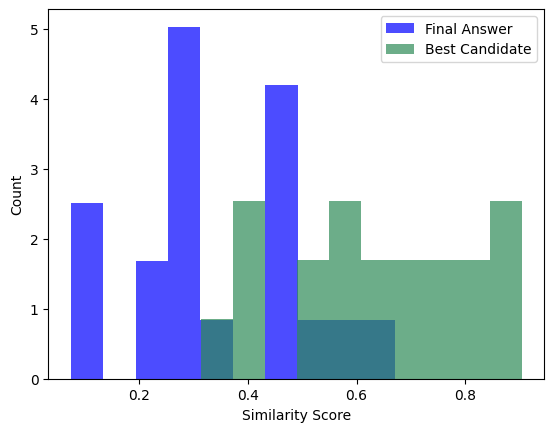

In [34]:
final_ans_scores = []
best_candidate_scores = []
for res in results:
    final_ans_scores.append(res['final answer similarity score'])
    best_candidate_scores.append(res['best similarity score'])

import matplotlib.pyplot as plt
plt.hist(final_ans_scores, alpha=0.7, label='Final Answer', color='blue', density=True)
plt.hist(best_candidate_scores, alpha=0.7, label='Best Candidate', color='seagreen', density=True)
plt.xlabel('Similarity Score')
plt.ylabel('Count')
plt.legend(['Final Answer', 'Best Candidate'])
plt.show()

In [28]:
with open('results/eval_tot_0_99.pkl', 'rb') as f:
    data = pickle.load(f)

In [399]:
tot_data = pickle.load(open('results/eval_tot_0_99.pkl', 'rb'))
gprofiler_data = pickle.load(open('results/eval_gprofiler_0_99.pkl', 'rb'))
medagents_data = pickle.load(open('results/eval_medagents_gprofiler_0_99.pkl', 'rb'))

In [400]:
results_final_ans = []
results_best_candidate = []
for i in range(55):
    if len(tot_data) > i:
        tot_final_ans = tot_data[i]['final answer']
        tot_best_candidate = tot_data[i]['best candidate process']
        tot_final_ans_score = tot_data[i]['final answer similarity quantile']
        tot_best_candidate_score = tot_data[i]['best candidate similarity quantile']
    else:
        tot_final_ans = None
        tot_best_candidate = None
        tot_final_ans_score = None
        tot_best_candidate_score = None
    if len(gprofiler_data) > i:
        gprofiler_final_ans = gprofiler_data[i]['final answer']
        gprofiler_best_candidate = gprofiler_data[i]['best candidate process']
        gprofiler_final_ans_score = gprofiler_data[i]['final answer similarity quantile']
        gprofiler_best_candidate_score = gprofiler_data[i]['best candidate similarity quantile']
    else:
        gprofiler_final_ans = None
        gprofiler_best_candidate = None
        gprofiler_final_ans_score = None
        gprofiler_best_candidate_score = None
    if len(medagents_data) > i:
        medagents_final_ans = medagents_data[i]['final answer']
        medagents_best_candidate = medagents_data[i]['best candidate process']
        medagents_final_ans_score = medagents_data[i]['final answer similarity quantile']
        medagents_best_candidate_score = medagents_data[i]['best candidate similarity quantile']
    else:
        medagents_final_ans = None
        medagents_best_candidate = None
        medagents_final_ans_score = None
        medagents_best_candidate_score = None


    results_final_ans.append({'tot': tot_final_ans_score, 'gprofiler': gprofiler_final_ans_score, 'medagents': medagents_final_ans_score})
    results_best_candidate.append({'tot': tot_best_candidate_score, 'gprofiler': gprofiler_best_candidate_score, 'medagents': medagents_best_candidate_score})


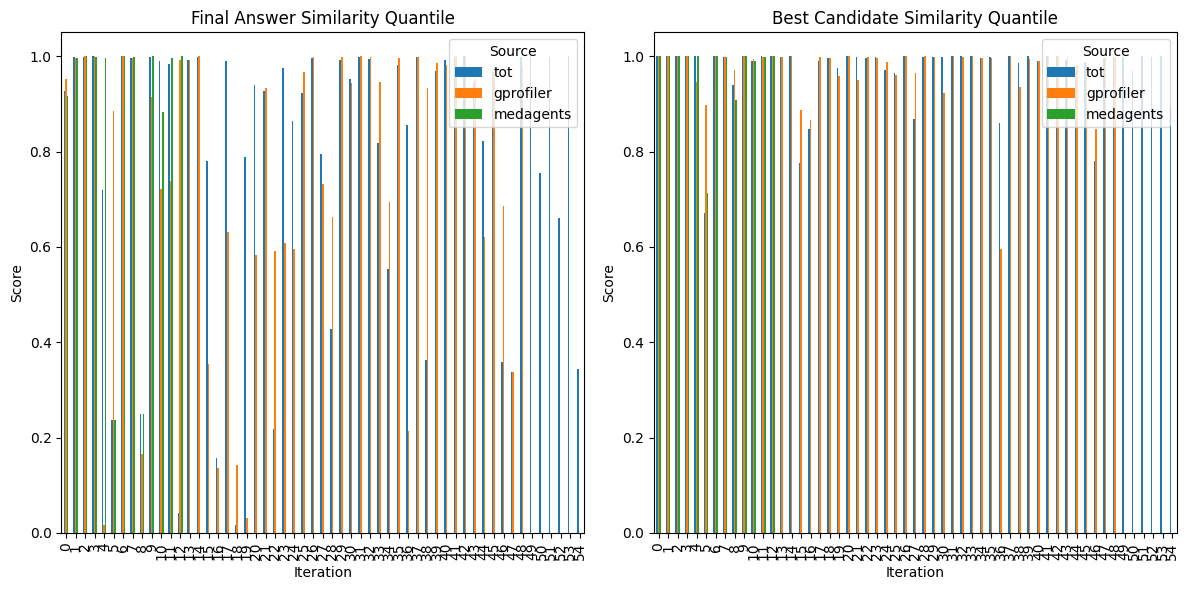

In [401]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming results_final_ans and results_best_candidate are already populated as per your code
df_final_ans = pd.DataFrame(results_final_ans)
df_best_candidate = pd.DataFrame(results_best_candidate)

# Replace None with NaN for proper handling in plots
df_final_ans = df_final_ans.fillna(value=np.nan)
df_best_candidate = df_best_candidate.fillna(value=np.nan)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df_final_ans.plot(kind='bar', ax=plt.gca())
plt.title('Final Answer Similarity Quantile')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.legend(title='Source')

plt.subplot(1, 2, 2)
df_best_candidate.plot(kind='bar', ax=plt.gca())
plt.title('Best Candidate Similarity Quantile')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.legend(title='Source')

plt.tight_layout()
plt.show()


In [402]:
import pandas as pd

# Assuming results_final_ans and results_best_candidate are already populated as per your code
df_final_ans = pd.DataFrame(results_final_ans)
df_best_candidate = pd.DataFrame(results_best_candidate)

# Replace None with NaN for proper handling in calculations
df_final_ans = df_final_ans.fillna(value=np.nan)
df_best_candidate = df_best_candidate.fillna(value=np.nan)

# Calculate means
mean_final_ans = df_final_ans.iloc[:50].mean()
mean_best_candidate = df_best_candidate.iloc[:50].mean()

print("Mean Final Answer Similarity Quantile:")
print(mean_final_ans)
print("\nMean Best Candidate Similarity Quantile:")
print(mean_best_candidate)


Mean Final Answer Similarity Quantile:
tot          0.796311
gprofiler    0.766599
medagents    0.866849
dtype: float64

Mean Best Candidate Similarity Quantile:
tot          0.970201
gprofiler    0.971513
medagents    0.969480
dtype: float64


In [403]:
import pandas as pd
import numpy as np

# Assuming results_final_ans and results_best_candidate are already populated as per your code
df_final_ans = pd.DataFrame(results_final_ans)
df_best_candidate = pd.DataFrame(results_best_candidate)

# Replace None with NaN for proper handling in calculations
df_final_ans = df_final_ans.fillna(value=np.nan)
df_best_candidate = df_best_candidate.fillna(value=np.nan)

# Proportion of scores > 0.98
proportion_final_ans_above_98 = (df_final_ans.iloc[:55] > 0.98).sum() / 55
proportion_best_candidate_above_98 = (df_best_candidate.iloc[:55] > 0.98).sum() / 55

print("Proportion of Final Answer Similarity Scores > 0.98:")
print(proportion_final_ans_above_98)
print("\nProportion of Best Candidate Similarity Scores > 0.98:")
print(proportion_best_candidate_above_98)


Proportion of Final Answer Similarity Scores > 0.98:
tot          0.436364
gprofiler    0.327273
medagents    0.163636
dtype: float64

Proportion of Best Candidate Similarity Scores > 0.98:
tot          0.763636
gprofiler    0.654545
medagents    0.200000
dtype: float64


# Analysis

In [68]:
gprofiler_data[0]
print(json.loads(gprofiler_data[0]['ys'][0]))

{'Step': '5', 'Relation': 'has part', 'Reason': 'Clathrin-mediated endocytosis is a specific mechanism by which LDL cholesterol endocytosis occurs. The gene LDLRAP1 is important in the formation of clathrin-coated vesicles which are essential for the internalization of LDL particles.', 'Biological Process': 'Clathrin-mediated endocytosis of LDL'}


In [74]:
for i in range(1, 4):
    dic = gprofiler_data[i]
    genes = task.get_input(dic['index'])
    final_ans = dic['final answer']
    final_ans_similarity_score = dic['final answer similarity score']
    final_ans_similarity_quantile = dic['final answer similarity quantile']
    label = dic['label']
    trie = dic['trie']
    dot = trie.visualize()
    dot.render('jiawei_examples/trie_visualization_{}'.format(i), format='png')
    print('Genes:', genes)
    print('Final answer:', final_ans)
    print('Final answer similarity score:', final_ans_similarity_score)
    print('Final answer similarity quantile:', final_ans_similarity_quantile)
    print('True answer:', label)

    print()
    

Genes: NOD1 HLA-DRA CLEC4A HLA-DRB1 CCL21 NOD2 CCL19 SLC11A1 HLA-DRB3 CCR7 CD68 FCGR2B THBS1 FGL2 CD74
Final answer: positive regulation of MHC class II biosynthesis
Final answer similarity score: 0.45106328
Final answer similarity quantile: 0.9953332241689864
True answer: dendritic cell antigen processing and presentation

Genes: OGG1 ERCC5 XPA ERCC4 NTHL1
Final answer: DNA damage recognition in GG-NER
Final answer similarity score: 0.71089345
Final answer similarity quantile: 0.9995906336990339
True answer: nucleotide-excision repair, DNA incision

Genes: SLC7A11 SLC25A39 SLC26A6 ABCB9 SLC15A4 ABCC5 CDH17 SLC15A3 ABCC4 SLC13A3 GJA1 SLC15A1 SLC15A2 ABCC1 CA2
Final answer: Brush border oligopeptide translocation
Final answer similarity score: 0.69717884
Final answer similarity quantile: 0.9997543802194203
True answer: oligopeptide transmembrane transport



In [ ]:
final_answer_simimarity_quantiles = []
best_candidate_simimarity_quantiles = []
for res in results:
    final_answer_simimarity_quantiles.append(res['final answer similarity quantile'])
    best_candidate_simimarity_quantiles.append(res['best candidate similarity quantile'])
    

In [319]:
def get_terms_by_layer(trie):
    layers = {}
    layer_num = 1
    root = trie.root
    queue = [root]
    while queue:
        children = []
        layer = []
        for node in queue:
            if node.children:
                children.extend(node.children.values())
                layer.extend(node.children.keys())
        if layer:
            layers[layer_num] = layer
            queue = children
            layer_num += 1
        else:
            break
    return layers

In [324]:
# tot_data_by_layer = {}
for idx in range(49, 56):
    print(idx)
    example_dic = {}
    tot_data_dict = tot_data[idx]
    genes = task.get_input(idx)
    num_genes = len(genes.split(' '))
    label = tot_data_dict['label']
    trie = tot_data_dict['trie']
    layers = get_terms_by_layer(trie)
    best_answer = tot_data_dict['best candidate process']
    example_dic = {'genes': genes, 'num_genes': num_genes, 'label': label, 'best answer': best_answer, 'layers': {}}
    for layer_num, terms in layers.items():
        layer_dic = {}
        for term in terms:
            term_sim_score = similarity_score(term, label)
            term_sim_quantile = similarity_percentile(term_sim_score, term)
            layer_dic[term] = {'similarity score': term_sim_score, 'similarity quantile': term_sim_quantile}
        example_dic['layers'][layer_num] = layer_dic
    tot_data_by_layer[idx] = example_dic


49
50
51
52
53
54
55


IndexError: list index out of range

In [190]:
len(tot_data_by_layer.keys())

49

In [381]:
quantiles_by_layer = {}
for idx, example_dic in tot_data_by_layer.items():
    for layer_num, terms in example_dic['layers'].items():
        for term, term_dic in terms.items():
            quantile = term_dic['similarity quantile']
            if layer_num not in quantiles_by_layer.keys():
                quantiles_by_layer[layer_num] = []
            quantiles_by_layer[layer_num].append(quantile)

In [382]:
# get average quantile by layer
avg_quantiles_by_layer = {}
for layer_num, quantiles in quantiles_by_layer.items():
    avg_quantiles_by_layer[layer_num] = np.median(quantiles)
avg_quantiles_by_layer

{1: 0.6099557884394956,
 2: 0.7992467660062224,
 3: 0.9025708203700671,
 4: 0.8945472408711315,
 5: 0.8870558375634517}

In [327]:
proportion_quantiles_above_98_by_layer = {}
for layer_num, quantiles in quantiles_by_layer.items():
    proportion_quantiles_above_98_by_layer[layer_num] = (np.array(quantiles) > 0.98).mean()
proportion_quantiles_above_98_by_layer

{1: 0.11515151515151516,
 2: 0.20723684210526316,
 3: 0.3028391167192429,
 4: 0.31384615384615383,
 5: 0.32407407407407407}

In [350]:
scores_by_layer = {}
for idx, example_dic in tot_data_by_layer.items():
    for layer_num, terms in example_dic['layers'].items():
        for term, term_dic in terms.items():
            score = term_dic['similarity score']
            if layer_num not in scores_by_layer.keys():
                scores_by_layer[layer_num] = []
            scores_by_layer[layer_num].append(score)

In [351]:
# get avg score by layer
avg_scores_by_layer = {}
for layer_num, scores in scores_by_layer.items():
    avg_scores_by_layer[layer_num] = np.mean(scores)
avg_scores_by_layer

{1: 0.32917595, 2: 0.39679387, 3: 0.4350589, 4: 0.42572117, 5: 0.42237636}

In [353]:
# find best answer location
best_answer_location = [] # first instance
num_genes = []
best_ans_location_dic = {}
for idx, example_dic in tot_data_by_layer.items():
    found = False
    best_answer = tot_data[idx]['best candidate process']
    for layer_num, terms in example_dic['layers'].items():
        if found:
            break
        for term, term_dic in terms.items():
            if term == example_dic['best answer']:
                best_answer_location.append(layer_num)
                num_genes.append(example_dic['num_genes'])
                if layer_num not in best_ans_location_dic.keys():
                    best_ans_location_dic[layer_num] = []
                best_ans_location_dic[layer_num].append(idx)
                found = True
                break
            

In [354]:
for k, v in best_ans_location_dic.items():
    print(k, np.mean(v))

2 22.142857142857142
1 41.625
5 17.25
3 31.923076923076923
4 24.083333333333332


In [393]:
best_ans_location_counts = {}
for layer_num in best_ans_location_dic.keys():
    best_ans_location_counts[layer_num] = len(best_ans_location_dic[layer_num]) / len(tot_data_by_layer.keys())
best_ans_location_counts

{2: 0.2545454545454545,
 1: 0.14545454545454545,
 5: 0.14545454545454545,
 3: 0.23636363636363636,
 4: 0.21818181818181817}

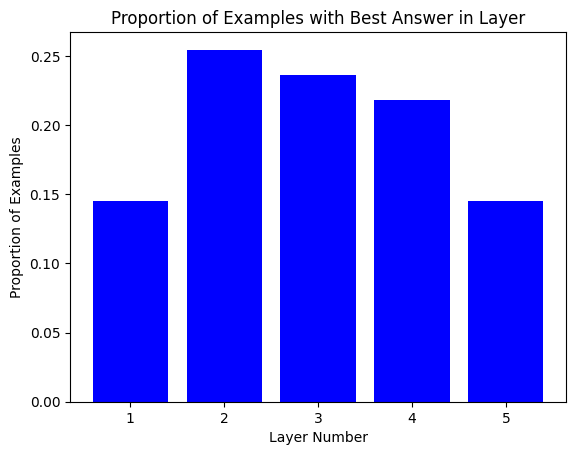

In [398]:
plt.bar(best_ans_location_counts.keys(), best_ans_location_counts.values(), color='blue')
plt.xlabel('Layer Number')
plt.ylabel('Proportion of Examples')
plt.title('Proportion of Examples with Best Answer in Layer')
plt.show()

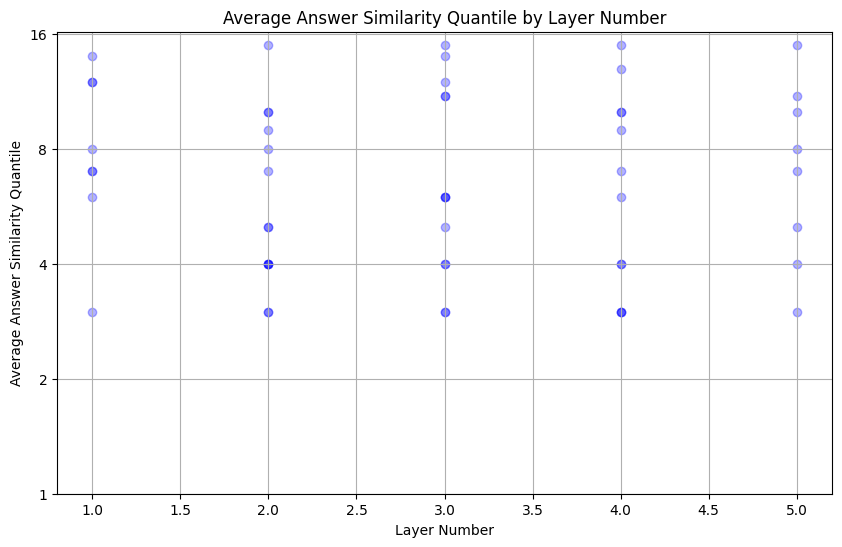

In [363]:
# Now, create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(best_answer_location, num_genes, alpha=0.3, color='blue')  # Choose a color you prefer
plt.xlabel('Layer Number')
plt.ylabel('Num Genes')
plt.title('Num Genes in Best Answer vs Layer Number')
# Set y-axis to log scale
plt.yscale('log', base=2)
# plt.set_yscale('log', base=2)

# Set the y-axis ticks to be 1, 2, 4, 8, 16, 32, 64
plt.yticks([1, 2, 4, 8, 16], ['1', '2', '4', '8', '16'])
plt.grid(True)
plt.show()

In [331]:
# similarity quantile by number of genes
final_ans_quantile = []
num_genes = []
best_ans_quantile = []
for idx, example_dic in tot_data_by_layer.items():
    # print(idx)
    best_ans_quantile .append(tot_data[idx]['best candidate similarity quantile'])
    final_ans_quantile.append(tot_data[idx]['final answer similarity quantile'])
    num_genes.append(example_dic['num_genes'])
    

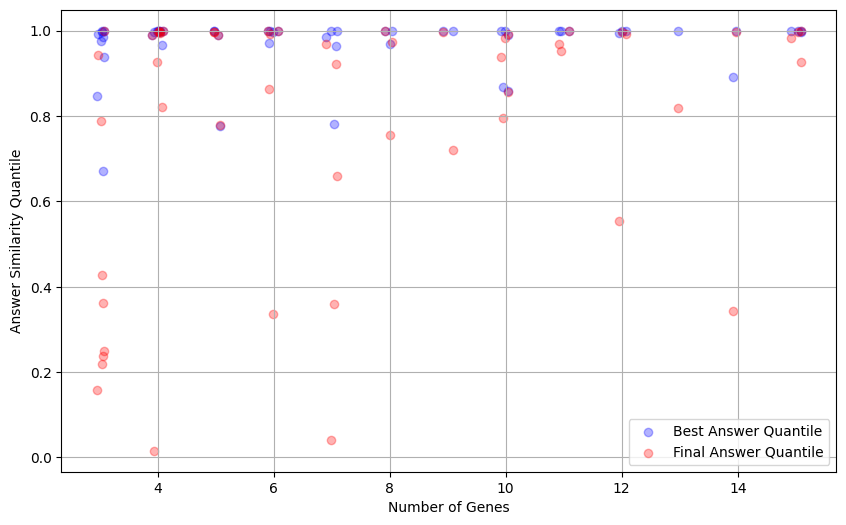

In [338]:
# Jitter the 'num_genes' data to help prevent overlap
jitter_strength = 0.1  # adjust this value as needed
jittered_num_genes = num_genes + np.random.uniform(-jitter_strength, jitter_strength, size=len(num_genes))

# Create a scatter plot with jittered data and semi-transparent points for the best answer quantile
plt.figure(figsize=(10, 6))
plt.scatter(jittered_num_genes, best_ans_quantile, alpha=0.3, color='blue', label='Best Answer Quantile')

# Add the final answer quantile in red
plt.scatter(jittered_num_genes, final_ans_quantile, alpha=0.3, color='red', label='Final Answer Quantile')

plt.xlabel('Number of Genes')
plt.ylabel('Answer Similarity Quantile')
plt.title('Answer Similarity Quantile vs Number of Genes')
plt.legend()  # Add a legend to distinguish the datasets
plt.grid(True)
plt.show()


In [ ]:
final_ans_similarity_score = []
num_genes = []
best_ans_similarity_score = []
for idx, example_dic in tot_data_by_layer.items():
    # print(idx)
    best_ans_similarity_score.append(tot_data[idx]['best similarity score'])
    final_ans_similarity_score.append(tot_data[idx]['final answer similarity score'])
    num_genes.append(example_dic['num_genes'])

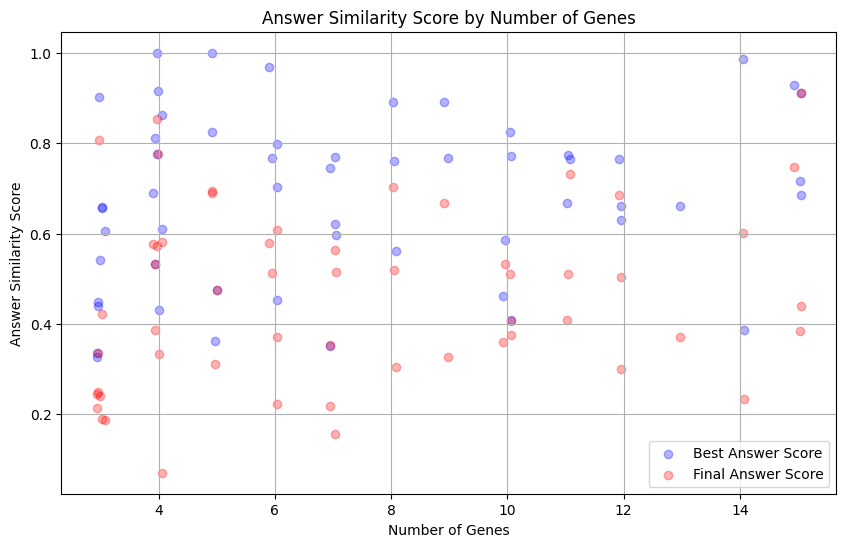

In [380]:
# Jitter the 'num_genes' data to help prevent overlap
jitter_strength = 0.1  # adjust this value as needed
jittered_num_genes = num_genes + np.random.uniform(-jitter_strength, jitter_strength, size=len(num_genes))

# Create a scatter plot with jittered data and semi-transparent points for the best answer quantile
plt.figure(figsize=(10, 6))
plt.scatter(jittered_num_genes, best_ans_similarity_score, alpha=0.3, color='blue', label='Best Answer Score')

# Add the final answer quantile in red
plt.scatter(jittered_num_genes, final_ans_similarity_score, alpha=0.3, color='red', label='Final Answer Score')

plt.xlabel('Number of Genes')
plt.ylabel('Answer Similarity Score')
plt.title('Answer Similarity Score by Number of Genes')
plt.legend()  # Add a legend to distinguish the datasets
plt.grid(True)
plt.show()


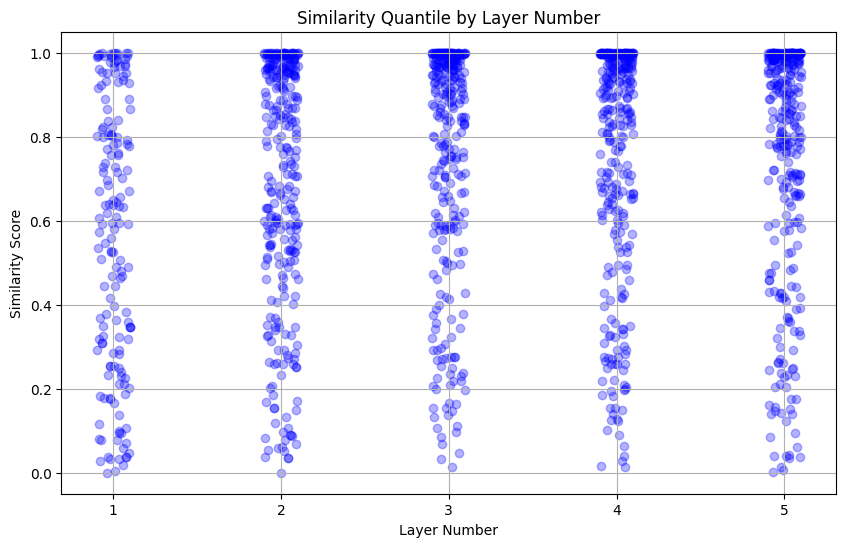

In [378]:
# Prepare the lists for plotting
layer_nums = []
quantiles = []
for layer_num, quantile_lst in quantiles_by_layer.items():
    for quantile in quantile_lst:
        layer_nums.append(layer_num)
        quantiles.append(quantile)



# Since layer numbers are typically discrete, you may want to jitter them slightly to see if any are overlapping
jitter_strength = 0.1  # adjust this value as needed
jittered_layer_nums = np.array(layer_nums) + np.random.uniform(-jitter_strength, jitter_strength, size=len(layer_nums))

# Now, create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(jittered_layer_nums, quantiles, alpha=0.3, color='blue')  # Choose a color you prefer
plt.xlabel('Layer Number')
plt.ylabel('Similarity Score')
plt.title('Similarity Quantile by Layer Number')
plt.grid(True)
plt.show()

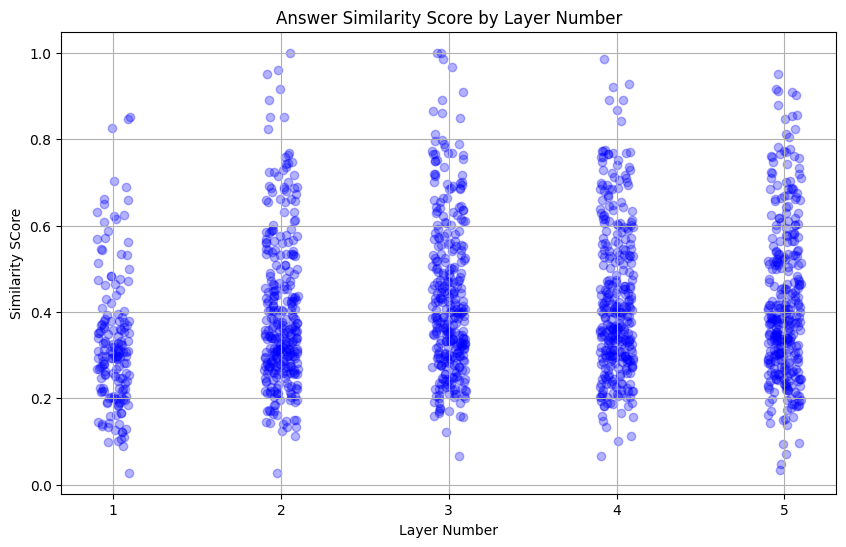

In [387]:
# Prepare the lists for plotting
layer_nums = []
scores = []
for layer_num, score_lst in scores_by_layer.items():
    for score in score_lst:
        layer_nums.append(layer_num)
        scores.append(score)

# Since layer numbers are typically discrete, you may want to jitter them slightly to see if any are overlapping
jitter_strength = 0.1  # adjust this value as needed
jittered_layer_nums = np.array(layer_nums) + np.random.uniform(-jitter_strength, jitter_strength, size=len(layer_nums))

# Now, create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(jittered_layer_nums, scores, alpha=0.3, color='blue')  # Choose a color you prefer
plt.xlabel('Layer Number')
plt.ylabel('Similarity SCore')
plt.title('Answer Similarity Score by Layer Number')
plt.grid(True)
plt.show()

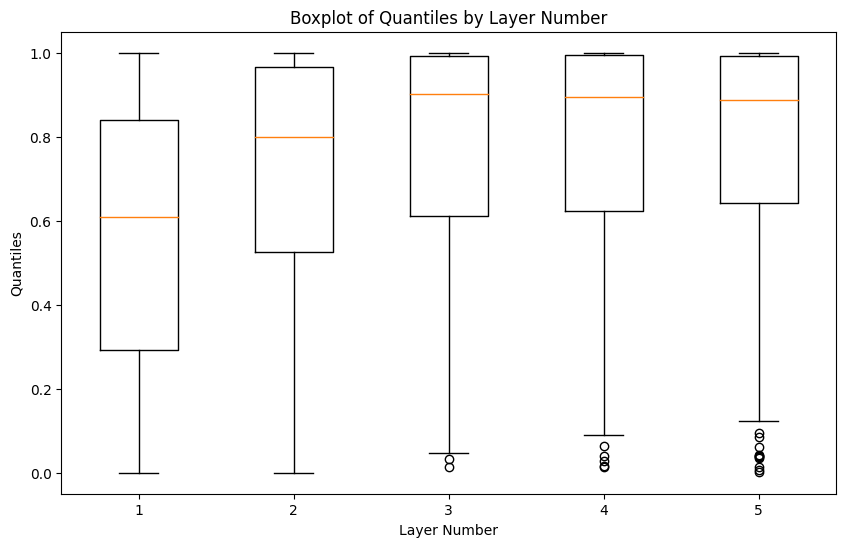

In [340]:
# Now create a box plot
plt.figure(figsize=(10, 6))

# Group the quantiles by layer numbers
layer_groups = [[] for _ in range(max(layer_nums) + 1)]  # create a list of lists for groups
for num, quantile in zip(layer_nums, quantiles):
    layer_groups[num].append(quantile)

# Remove the empty first group if layer numbers start from 1
if layer_nums[0] == 1:
    layer_groups = layer_groups[1:]

# Create the box plot
plt.boxplot(layer_groups)
plt.xlabel('Layer Number')
plt.ylabel('Quantiles')
plt.title('Boxplot of Quantiles by Layer Number')
plt.grid(False)
plt.show()

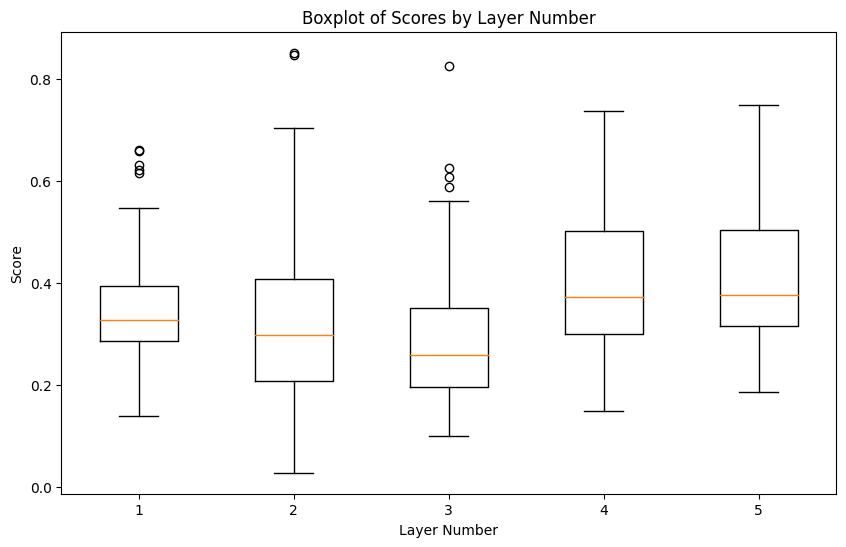

In [377]:
# Now create a box plot
plt.figure(figsize=(10, 6))

# Group the quantiles by layer numbers
layer_groups = [[] for _ in range(max(layer_nums) + 1)]  # create a list of lists for groups
for num, score in zip(layer_nums, scores):
    layer_groups[num].append(score)

# Remove the empty first group if layer numbers start from 1
if layer_nums[0] == 1:
    layer_groups = layer_groups[1:]

# Create the box plot
plt.boxplot(layer_groups)
plt.xlabel('Layer Number')
plt.ylabel('Score')
plt.title('Boxplot of Scores by Layer Number')
plt.grid(False)
plt.show()

In [371]:
# select best quantile by layer
best_quantile_by_layer = {}
for idx, example_dic in tot_data_by_layer.items():
    for layer_num, terms in example_dic['layers'].items():
        if layer_num not in best_quantile_by_layer.keys():
            best_quantile_by_layer[layer_num] = []
        layer_quantiles = []
        for term, term_dic in terms.items():
            quantile = term_dic['similarity quantile']
            layer_quantiles.append(quantile)
        best_quantile_by_layer[layer_num].append(np.max(layer_quantiles))


In [372]:
best_quantiles = []
layer_nums = []
for layer_num, quantile_lst in best_quantile_by_layer.items():
    for quantile in quantile_lst:
        layer_nums.append(layer_num)
        best_quantiles.append(quantile)

In [373]:
best_score_by_layer = {}
for idx, example_dic in tot_data_by_layer.items():
    for layer_num, terms in example_dic['layers'].items():
        if layer_num not in best_score_by_layer.keys():
            best_score_by_layer[layer_num] = []
        layer_scores = []
        for term, term_dic in terms.items():
            score = term_dic['similarity score']
            layer_scores.append(score)
        best_score_by_layer[layer_num].append(np.max(layer_scores))

In [374]:
best_scores = []
layer_nums = []
for layer_num, score_lst in best_score_by_layer.items():
    for score in score_lst:
        layer_nums.append(layer_num)
        best_scores.append(score)

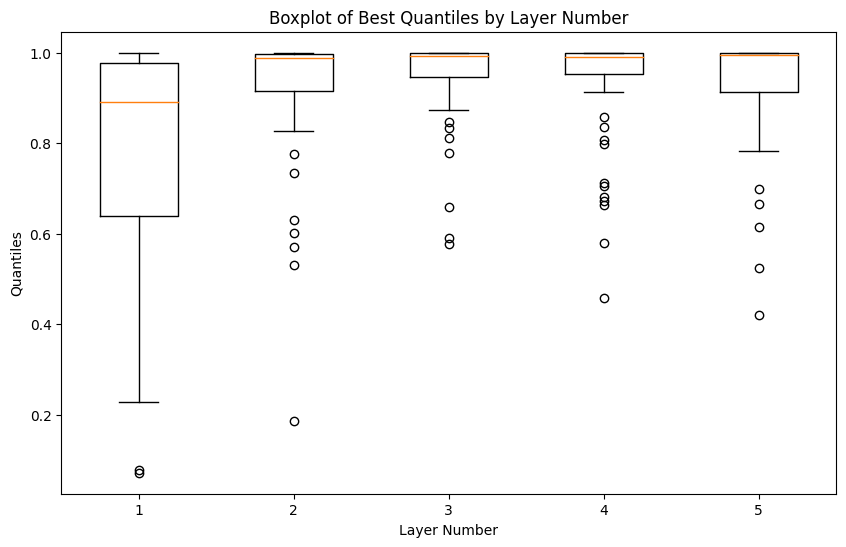

In [343]:
# Now create a box plot
plt.figure(figsize=(10, 6))

# Group the quantiles by layer numbers
layer_groups = [[] for _ in range(max(layer_nums) + 1)]  # create a list of lists for groups
for num, quantile in zip(layer_nums, best_quantiles):
    layer_groups[num].append(quantile)

# Remove the empty first group if layer numbers start from 1
if layer_nums[0] == 1:
    layer_groups = layer_groups[1:]

# Create the box plot
plt.boxplot(layer_groups)
plt.xlabel('Layer Number')
plt.ylabel('Quantiles')
plt.title('Boxplot of Best Quantiles by Layer Number')
plt.grid(False)
plt.show()

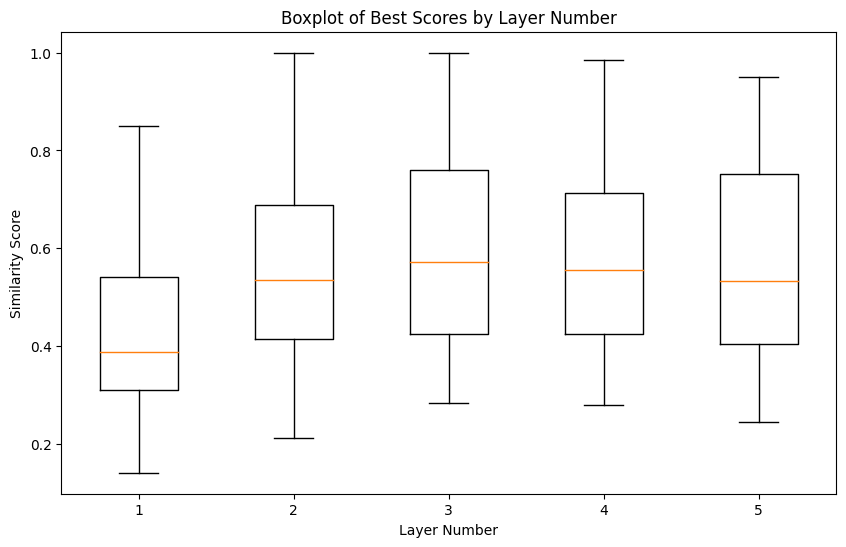

In [376]:
# Now create a box plot
plt.figure(figsize=(10, 6))

# Group the quantiles by layer numbers
layer_groups = [[] for _ in range(max(layer_nums) + 1)]  # create a list of lists for groups
for num, score in zip(layer_nums, best_scores):
    layer_groups[num].append(score)

# Remove the empty first group if layer numbers start from 1
if layer_nums[0] == 1:
    layer_groups = layer_groups[1:]

# Create the box plot
plt.boxplot(layer_groups)
plt.xlabel('Layer Number')
plt.ylabel('Similarity Score')
plt.title('Boxplot of Best Scores by Layer Number')
plt.grid(False)
plt.show()

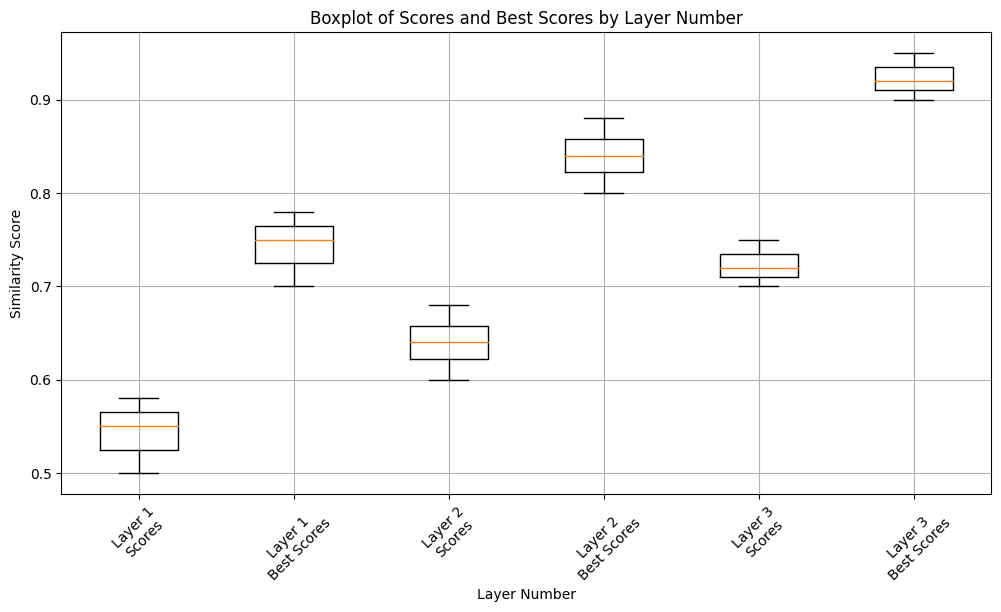

In [390]:
import matplotlib.pyplot as plt

# Sample data
layer_nums = [1, 2, 1, 2, 3, 2, 3, 1, 2, 3]  # Replace with your actual layer numbers
scores = [0.5, 0.6, 0.55, 0.65, 0.7, 0.68, 0.72, 0.58, 0.63, 0.75]  # Replace with your actual scores
best_scores = [0.7, 0.8, 0.75, 0.85, 0.9, 0.88, 0.92, 0.78, 0.83, 0.95]  # Replace with your actual best scores

# Group the scores and best scores by layer numbers
max_layer = max(layer_nums)
layer_groups = {i: {'scores': [], 'best_scores': []} for i in range(1, max_layer + 1)}

for num, score, best_score in zip(layer_nums, scores, best_scores):
    layer_groups[num]['scores'].append(score)
    layer_groups[num]['best_scores'].append(best_score)

# Prepare data for plotting
plot_data = []
for i in range(1, max_layer + 1):
    plot_data.append(layer_groups[i]['scores'])
    plot_data.append(layer_groups[i]['best_scores'])

# Create the box plot
plt.figure(figsize=(12, 6))
plt.boxplot(plot_data)

# Customizing the x-axis labels
xtick_labels = []
for i in range(1, max_layer + 1):
    xtick_labels.append(f'Layer {i}\nScores')
    xtick_labels.append(f'Layer {i}\nBest Scores')

plt.xticks(range(1, 2 * max_layer + 1), xtick_labels, rotation=45)
plt.xlabel('Layer Number')
plt.ylabel('Similarity Score')
plt.title('Boxplot of Scores and Best Scores by Layer Number')
plt.grid(True)
plt.show()


In [344]:
len(best_quantiles)

275

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categor

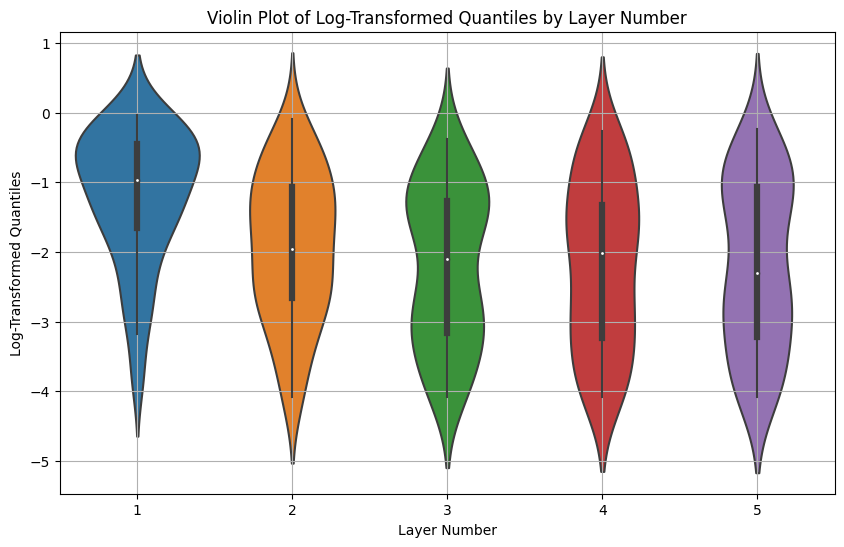

In [345]:
transformed_quantiles = np.log10(1-np.array(best_quantiles) + 1e-6)

# Now create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x=layer_nums, y=transformed_quantiles)
plt.xlabel('Layer Number')
plt.ylabel('Log-Transformed Quantiles')
plt.title('Violin Plot of Log-Transformed Quantiles by Layer Number')
plt.grid(True)
plt.show()

In [385]:
proportion_best_quantiles_above_98_by_layer = {}
for layer_num, quantiles in best_quantile_by_layer.items():
    proportion_best_quantiles_above_98_by_layer[layer_num] = (np.array(quantiles) > 0.98).mean()
proportion_best_quantiles_above_98_by_layer

{1: 0.23636363636363636,
 2: 0.5454545454545454,
 3: 0.5454545454545454,
 4: 0.6,
 5: 0.6}

In [384]:
avg_best_quantile_by_layer = {}
for layer_num, quantiles in best_quantile_by_layer.items():
    avg_best_quantile_by_layer[layer_num] = np.median(quantiles)
avg_best_quantile_by_layer

{1: 0.8906173243818569,
 2: 0.9887833633535288,
 3: 0.9919764205010644,
 4: 0.9902570820370067,
 5: 0.9950876043884067}

In [386]:
avg_best_score_by_layer = {}
for layer_num, scores in best_score_by_layer.items():
    avg_best_score_by_layer[layer_num] = np.mean(scores)
avg_best_score_by_layer

{1: 0.43488458, 2: 0.56120664, 3: 0.5932997, 4: 0.57538104, 5: 0.572414}

In [296]:
test_trie = tot_data[0]['trie']

In [348]:
from graphviz import Digraph

def visualize_trie(trie):
    def add_nodes_edges(node, graph, parent_name=None, char=None, relation=""):
        node_name = f"{parent_name}{char}_{id(node)}" if parent_name else 'root'
        node_label = f'{char} ({node.value})' if node.value else char if char else 'root'
        node_shape = 'doublecircle' if node.is_end else 'ellipse'
        node_color = 'lightblue' if node.is_end else 'lightgrey'

        graph.node(node_name, label=node_label, shape=node_shape, style='filled', fillcolor=node_color)

        if parent_name:
            edge_style = 'dashed' if relation else 'solid'
            graph.edge(parent_name, node_name, label=relation, style=edge_style)

        for child_char, child_node in node.children.items():
            child_relation = node.relations.get(child_char, "")
            add_nodes_edges(child_node, graph, node_name, child_char, child_relation)

    graph = Digraph(comment='Trie Visualization', format='png')
    graph.attr('node', fontname='Arial')
    graph.attr(rankdir='LR', size='8,5')

    if trie.root:
        add_nodes_edges(trie.root, graph)

    return graph


In [301]:
trie_graph = visualize_trie(test_trie)
trie_graph.render('trie_visualization', view=True)  #

'trie_visualization.png'

In [305]:
test_trie = tot_data[0]['trie']

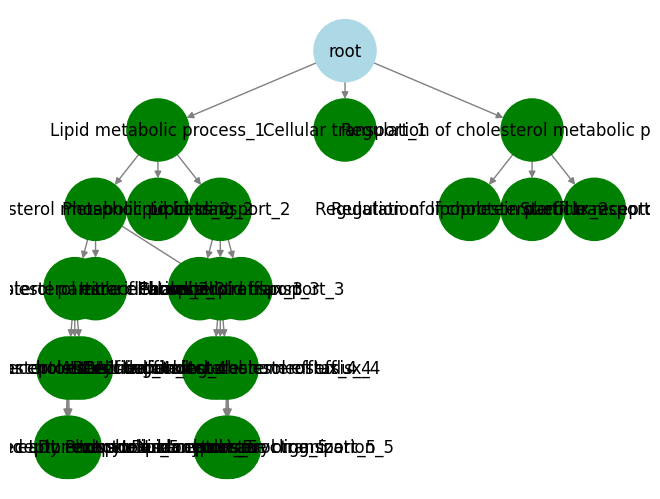

TypeError: visualize_trie_as_dag.<locals>.add_nodes_edges() missing 1 required positional argument: 'graph'

In [309]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def visualize_trie_as_dag(trie):
    G = nx.DiGraph()
    
    def add_nodes_edges(node, graph, parent_name=None, char=None, depth=0):
            # Define the node name, special handling for the root node
            node_name = f"{char}_{depth}" if parent_name is not None else 'root'

            # Add the node to the graph
            graph.add_node(node_name)
            if node.is_end:
                graph.nodes[node_name]['color'] = 'green'  # Mark end nodes
            else:
                graph.nodes[node_name]['color'] = 'lightblue'

            # Add an edge from the parent node if it's not the root
            if parent_name is not None:
                graph.add_edge(parent_name, node_name)

            # Recursively add child nodes and edges
            for child_char, child_node in node.children.items():
                add_nodes_edges(child_node, graph, node_name, child_char, depth + 1)

    # Add nodes and edges starting from the root
    add_nodes_edges(trie.root, G)

    # Define node positions using a hierarchical layout
    pos = hierarchy_pos(G, 'root')

    # Draw the graph
    colors = [G.nodes[n]['color'] for n in G.nodes]
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2000, edge_color='gray', font_size=12)

    plt.show()
    
    add_nodes_edges(trie.root)

    # Node positions using a hierarchical layout
    pos = hierarchy_pos(G, 'root')

    # Draw the graph
    colors = [G.nodes[n]['color'] for n in G.nodes]
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2000, edge_color='gray', font_size=12)

    plt.show()

def hierarchy_pos(G, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
    def _hierarchy_pos(G, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None):
        if pos is None:
            pos = {root: (xcenter, vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if parent is not None and parent in children:
            children.remove(parent)
        if len(children) != 0:
            dx = width / max(len(children), 1)
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G, child, width=dx, vert_gap=vert_gap, vert_loc=vert_loc - vert_gap, xcenter=nextx, pos=pos, parent=root)
        return pos

    return _hierarchy_pos(G, root, width=width, vert_gap=vert_gap, vert_loc=vert_loc, xcenter=xcenter)


# Usage
# ... (populate the trie) ...
visualize_trie_as_dag(test_trie)
